In [1]:
import numpy as np
from sedpy.observate import load_filters
from prospect.fitting import fit_model
from prospect.io import write_results as writer
from prospect.io import read_results as pread
from prospect.models import priors, transforms, sedmodel
from scipy.stats import truncnorm
import fsps
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({
    "savefig.facecolor": "w",
    "figure.facecolor" : 'w',
    "figure.figsize" : (10,8),
    "text.color": "k",
    "legend.fontsize" : 20,
    "font.size" : 30,
    "axes.edgecolor": "k",
    "axes.labelcolor": "k",
    "axes.linewidth": 3,
    "xtick.color": "k",
    "ytick.color": "k",
    "xtick.labelsize" : 25,
    "ytick.labelsize" : 25,
    "ytick.major.size" : 12,
    "xtick.major.size" : 12,
    "ytick.major.width" : 2,
    "xtick.major.width" : 2,
    "font.family": "Times",
    "mathtext.fontset" : "cm"
})

In [2]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps


def build_noise(**extras):
    return None, None

In [275]:
galex = ['galex_FUV', 'galex_NUV']
hst_wfc3_uv  = ['wfc3_uvis_f275w', 'wfc3_uvis_f336w', 'wfc3_uvis_f475w','wfc3_uvis_f555w', 'wfc3_uvis_f606w', 'wfc3_uvis_f814w']
sdss = ['sdss_i0']
hst_wfc3_ir = ['wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f140w', 'wfc3_ir_f160w']
spitzer_irac = ['spitzer_irac_ch1']
spitzer_mips = ['spitzer_mips_24']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']
jwst_miri = ['jwst_f560w', 'jwst_f770w', 'jwst_f1000w', 'jwst_f1130w', 'jwst_f1280w', 'jwst_f1500w', 'jwst_f1800w']
jwst_nircam = ['jwst_f070w', 'jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w']
filternames = (galex + hst_wfc3_uv +  hst_wfc3_ir + jwst_miri + jwst_nircam + 
               spitzer_irac + spitzer_mips + herschel_pacs + herschel_spire)

In [14]:
def get_best(res, **kwargs):
    imax = np.argmax(res['lnprobability'])
    theta_best = res['chain'][imax, :].copy()

    return theta_best
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

In [4]:
res, _, _ = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_matches_Obs.h5')
reskc, _, modkc = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_fixed_no_dust.h5')
rescal, _, modcal = pread.results_from('/Users/sidneylower/Documents/atten_demos/sfh4_dust4_Mod_Cal.h5')

In [9]:
def build_model():
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel

    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    model_params['tau']['prior'] = priors.LogUniform(mini=0.1, maxi=10)
    model_params['tage']['prior'] = priors.TopHat(mini=0.1, maxi=14.0)
    #model_params                                                                                                                                                                                               

    model_params['lumdist'] = {"N": 1, "isfree": False,"init": 1.0e-5,"units": "Mpc"}
    model_params['imf_type']['init'] = 2
    model_params['mass'] = {'N': 1, 'isfree': True, 'init': 1e10, 'prior' : priors.LogUniform(mini=1e7, maxi=1e13)}
    #model_params['logmass'] = {'N': 1,                                                                                                                                                                         
    #                    'isfree': False,                                                                                                                                                                       
    #                    'depends_on': massmet_to_logmass,                                                                                                                                                      
    #                    'init': 10.0,                                                                                                                                                                          
    #                    'units': 'Msun', 'prior': None}                                                                                                                                                        

    model_params['logzsol'] = {'N': 1, 'isfree': True, 'init': 0.0, 'prior' : priors.TopHat(mini=-1.9, maxi=0.2)}
    model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"}
    model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.3, sigma=1)
    model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars"}
    model_params["dust_index"] = {"N": 1, "isfree": True,
                         "init": -0.7, "units": "power-law multiplication of Calzetti",
                         "prior": priors.TopHat(mini=-1.8, maxi=0.2)}
    model_params["frac_nodust"] = {"N": 1, "isfree": True,
                         "init": 0.0, "units": "fraction of stars not attenuated by dust2",
                         "prior": priors.TopHat(mini=0.0, maxi=0.12)}
    model_params["uvb"] = {"N": 1, "isfree": True,
                         "init": 0.0, "units": "UV bump strength",
                         "prior": priors.TopHat(mini=0.0, maxi=3.0)}
    model_params['duste_gamma']['isfree'] = True
    model_params['duste_qpah']['isfree'] = False
    model_params['duste_qpah']['init'] = 5.86
    model_params['duste_umin']['isfree'] = True


    #model_params['massmet'] = {'N': 2,'isfree': True,'init': np.array([10,-0.5]), 'prior': None}                                                                                                               
    #model_params['massmet']['prior'] = MassMet(z_mini=-1.98, z_maxi=0.19, mass_mini=7, mass_maxi=13)                                                                                                           


    model = sedmodel.SedModel(model_params)


    return model

In [10]:
modog = build_model()

In [12]:
sps = build_sps()

In [17]:
thetas_og = get_best(res)
thetas_cal = get_best(rescal)
thetas_kc= get_best(reskc)

In [18]:
spec_og, _, _ = modog.mean_model(thetas_og, res['obs'], sps)
spec_cal, _, _ = modcal.mean_model(thetas_cal, rescal['obs'], sps)
spec_kc, _, _ = modkc.mean_model(thetas_kc, reskc['obs'], sps)


In [35]:
nodust_thetas = [3.5e11, -0.2, 0.0, 10.0, 1.0, 0.0, 0.0, -0.7, 0.0, 0.0]

In [36]:
spec_no_dust, _ , _ = modog.mean_model(nodust_thetas, rescal['obs'], sps)

In [24]:
spec_real, phot_real, _ = modog.mean_model(res['obs']['true_thetas'], rescal['obs'], sps)

In [25]:
spec_waves = sps.wavelengths
filter_waves = [x.wave_mean for x in res['obs']['filters']]
savedir = '/Users/sidneylower/Documents/atten_demos/'

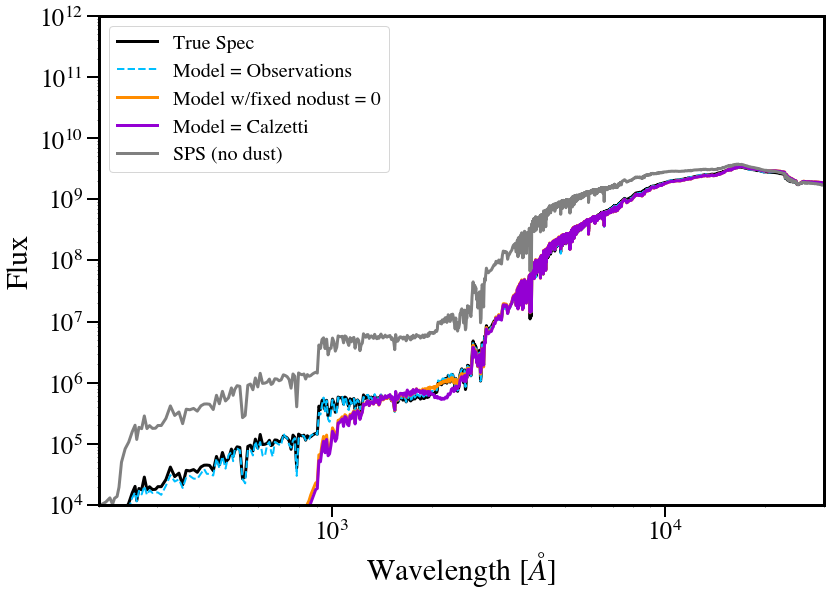

In [38]:
plt.figure(figsize=(13, 9))
plt.loglog(spec_waves, spec_real, color='black', lw=3, label='True Spec')
plt.loglog(spec_waves, spec_og, color='deepskyblue', ls='--', lw=2, label='Model = Observations')
plt.loglog(spec_waves, spec_cal, color='darkorange', lw=3, label='Model w/fixed nodust = 0')
plt.loglog(spec_waves, spec_kc, color='darkviolet', lw=3, label='Model = Calzetti')
plt.loglog(spec_waves, spec_no_dust, color='grey', lw=3, label='SPS (no dust)')
#plt.errorbar(filter_waves, phot_real, yerr=[x*0.03 for x in phot_real], color='black', ls='None',marker='o')
plt.ylim([1e4, 1e12])
plt.xlim([2e2, 3e4])
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\AA$]')
plt.legend(loc='upper left')
plt.savefig(savedir+'sed.png', dpi=300, bbox_inches='tight')

In [213]:
obs['maggies']

array([2.84372220e-04, 3.45507382e-04, 4.25594441e-04, 1.15643334e-03,
       7.86473473e-03, 1.19123825e-02, 1.65466049e-02, 3.69238245e-02,
       6.75504313e-02, 8.39599872e-02, 9.32845184e-02, 1.03425206e-01,
       4.84229487e-02, 2.64575230e-01, 1.68555774e-01, 3.45698819e-01,
       1.06681511e-01, 2.53717738e-01, 2.48471884e-01, 2.64058862e-02,
       4.97516234e-02, 7.67443183e-02, 1.00946128e-01, 1.26323309e-01,
       9.04171422e-02, 8.46766868e-02, 2.12697470e-01, 1.56900915e+00,
       4.48081416e+00, 8.82981643e+00, 7.16955629e+00, 3.94082852e+00,
       1.67887940e+00])

In [303]:
thetas = model.theta_labels()

In [427]:
mass_og = [np.log10(item[thetas.index('mass')]) for item in res['chain']]
mass_kcfixed = [np.log10(item[thetas.index('mass')]) for item in reskc['chain']]
mass_cal = [np.log10(item[thetas.index('mass')]) for item in resCal['chain']]

Text(10.2, 1.0, '$\\sigma$ = 0.66')

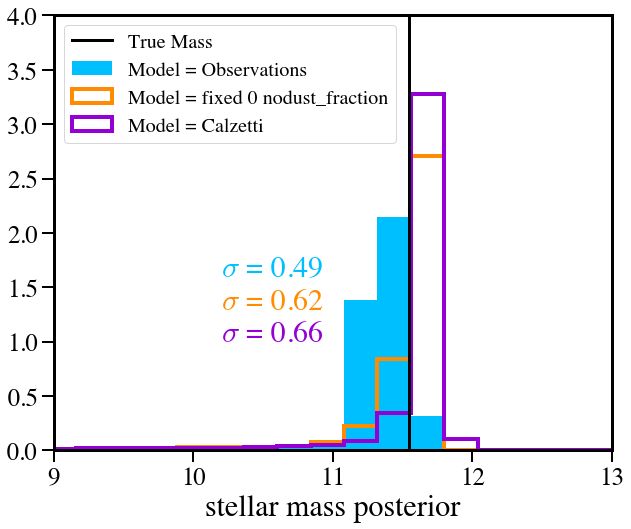

In [428]:
plt.hist(mass_og, range=(7, 13), bins=25, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(mass_kcfixed, range=(7, 13), bins=25, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(mass_cal, range=(7, 13), bins=25, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')
plt.plot([np.log10(reskc['obs']['true_thetas'][thetas.index('mass')]),np.log10(reskc['obs']['true_thetas'][thetas.index('mass')])], [0, 7], color='black', lw=3, label='True Mass')
plt.xlim([9, 13])
plt.ylim([0, 4])
plt.xlabel('stellar mass posterior')
plt.legend(loc='upper left', fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_og)), xy=(10.2, 1.6),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_kcfixed)), xy=(10.2, 1.3),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(mass_cal)), xy=(10.2, 1.),color='darkviolet')
#plt.savefig(savedir+'masses.png', dpi=300, bbox_inches='tight')

In [429]:
metal_og = [item[thetas.index('logzsol')] for item in res['chain']]
metal_kcfixed = [item[thetas.index('logzsol')] for item in reskc['chain']]
metal_cal = [item[thetas.index('logzsol')] for item in resCal['chain']]

Text(0.5, 0, 'Log(Z / Z$_{\\odot}$) posterior')

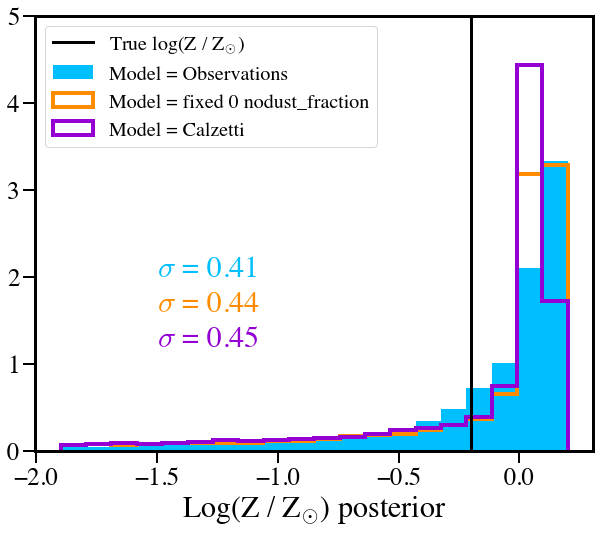

In [430]:
plt.hist(metal_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(metal_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(metal_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 5])
plt.plot([reskc['obs']['true_thetas'][thetas.index('logzsol')],reskc['obs']['true_thetas'][thetas.index('logzsol')]], [0, 7], color='black', lw=3, label='True log(Z / Z$_{\odot}$)')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_og)), xy=(-1.5, 2),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_kcfixed)), xy=(-1.5, 1.6),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(metal_cal)), xy=(-1.5, 1.2),color='darkviolet')
plt.xlabel('Log(Z / Z$_{\odot}$) posterior')
#plt.savefig(savedir+'Z.png', dpi=300, bbox_inches='tight')

In [363]:
tage_og = [3+item[thetas.index('tage')] for item in res['chain']]
tage_kcfixed = [item[thetas.index('tage')] for item in reskc['chain']]
tage_cal = [item[thetas.index('tage')] for item in resCal['chain']]

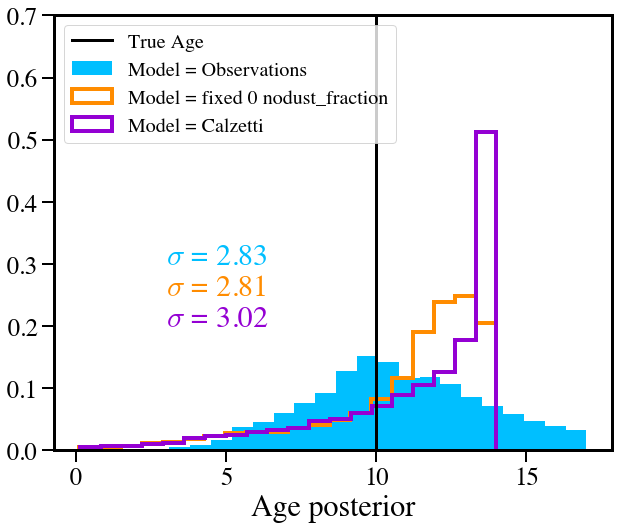

In [373]:
plt.hist(tage_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(tage_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_fraction')
plt.hist(tage_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 0.7])
plt.plot([reskc['obs']['true_thetas'][thetas.index('tage')], reskc['obs']['true_thetas'][thetas.index('tage')]], [0, 7], color='black', lw=3, label='True Age')

plt.legend(loc='upper left', fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_og)), xy=(3, 0.3),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_kcfixed)), xy=(3, 0.25),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tage_cal)), xy=(3, 0.2),color='darkviolet')
plt.xlabel('Age posterior')
plt.savefig(savedir+'age.png', dpi=300, bbox_inches='tight')

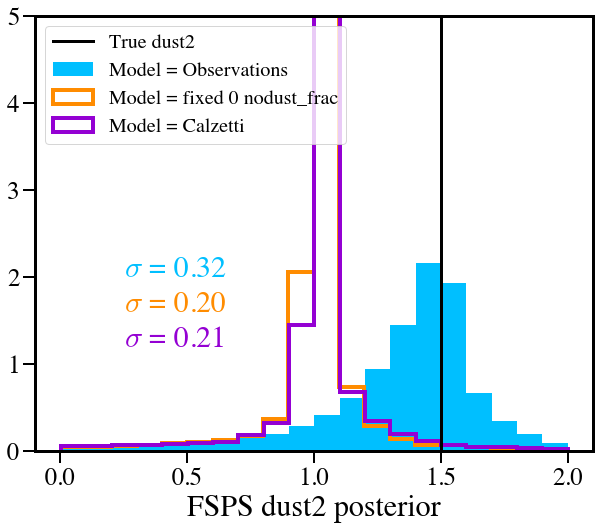

In [366]:
dust_og = [item[thetas.index('dust2')] for item in res['chain']]
dust_kcfixed = [item[thetas.index('dust2')] for item in reskc['chain']]
dust_cal = [item[thetas.index('dust2')] for item in resCal['chain']]
plt.hist(dust_og, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(dust_kcfixed, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = fixed 0 nodust_frac')
plt.hist(dust_cal, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti')

plt.ylim([0, 5])
plt.plot([reskc['obs']['true_thetas'][thetas.index('dust2')], reskc['obs']['true_thetas'][thetas.index('dust2')]], [0, 7], color='black', lw=3, label='True dust2')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_og)), xy=(0.25, 2),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_kcfixed)), xy=(0.25, 1.6),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_cal)), xy=(0.25, 1.2),color='darkviolet')
plt.xlabel('FSPS dust2 posterior')
plt.savefig(savedir+'Av.png', dpi=300, bbox_inches='tight')

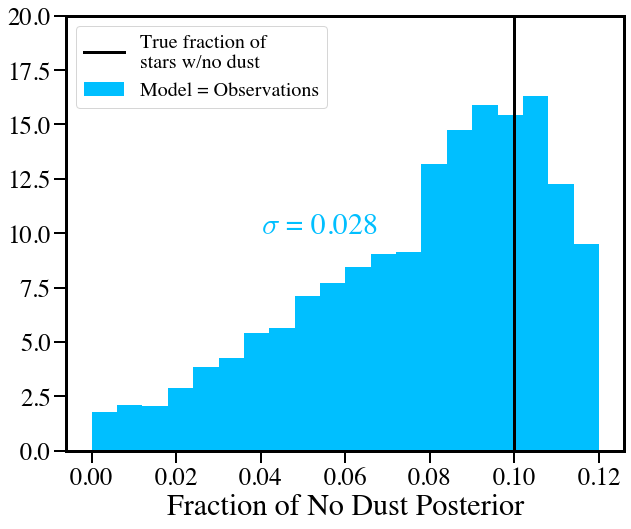

In [371]:
nodust_post = [item[thetas.index('frac_nodust')] for item in res['chain']]
plt.hist(nodust_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.plot([0.1, 0.1], [0, 20], color='black', lw=3, label='True fraction of\nstars w/no dust')
plt.ylim([0, 20])
plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.3f}".format(np.std(nodust_post)), xy=(0.04, 10),color='deepskyblue')
#plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(dust_cal)), xy=(0.5, 1.6),color='darkorange')
plt.xlabel('Fraction of No Dust Posterior')
plt.savefig(savedir+'frac_nodust.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'UV Bump Strength Posterior')

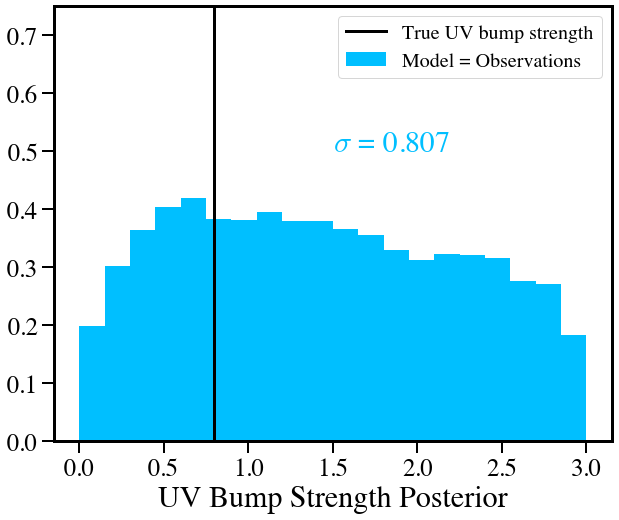

In [369]:
uvb_post = [item[thetas.index('uvb')] for item in res['chain']]
plt.hist(uvb_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.plot([0.8, 0.8], [0, 20], color='black', lw=3, label='True UV bump strength')
plt.ylim([0, 0.75])
plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.3f}".format(np.std(uvb_post)), xy=(1.5, 0.5),color='deepskyblue')
plt.xlabel('UV Bump Strength Posterior')

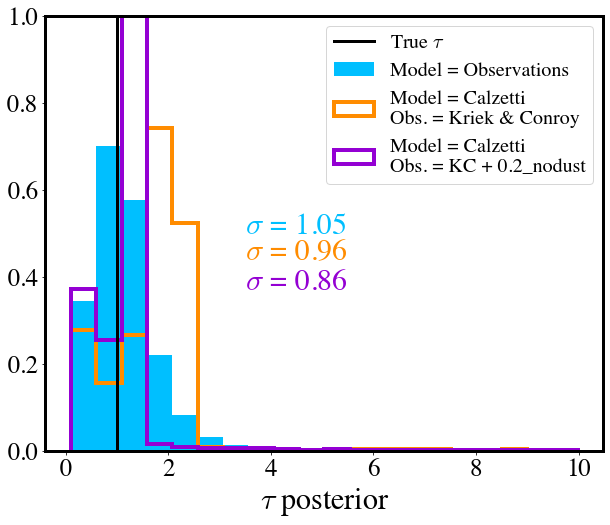

In [199]:
tau_post = [item[thetas.index('tau')] for item in res['chain']]
tau_post2 = [item[thetas.index('tau')] for item in res2['chain']]
tau_cal = [item[thetas.index('tau')] for item in resCal['chain']]
plt.hist(tau_post, bins=20, density=True, color='deepskyblue', label='Model = Observations')
plt.hist(tau_cal, bins=20, density=True, color='darkorange', lw=4, histtype='step', label='Model = Calzetti\nObs. = Kriek & Conroy')
plt.hist(tau_post2, bins=20, density=True, color='darkviolet', lw=4, histtype='step',label='Model = Calzetti\nObs. = KC + 0.2_nodust')

plt.ylim([0, 1])
plt.plot([1, 1], [0, 7], color='black', lw=3, label=r'True $\tau$')

plt.legend(fontsize=20)
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_post)), xy=(3.5, 0.5),color='deepskyblue')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_cal)), xy=(3.5, 0.44),color='darkorange')
plt.annotate('$\sigma$ = '+"{:.2f}".format(np.std(tau_post2)), xy=(3.5, 0.37),color='darkviolet')
plt.xlabel(r'$\tau$ posterior')
plt.savefig(savedir+'tau.png', dpi=300, bbox_inches='tight')

In [235]:
import pandas as pd

In [236]:
sed = pd.read_pickle('/Users/sidneylower/simba_ml_SEDs_z0.0.pkl')

In [237]:
props = pd.read_pickle('/Users/sidneylower/simba_ml_props_z0.0.pkl')

In [238]:
DL = 1e-5

In [242]:
from sedpy.observate import load_filters

In [239]:
sed.keys()

Index(['ID', 'Filters', 'Flux [Jy]', 'Flux Err'], dtype='object')

In [241]:
props.keys()

Index(['ID', 'stellar_mass', 'dust_mass', 'sfr', 'metallicity'], dtype='object')

In [244]:
sed['Filters']

0       [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
1       [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
2       [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
3       [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
4       [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
                              ...                        
1792    [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
1793    [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
1794    [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
1795    [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
1796    [galex_FUV, galex_NUV, wfc3_uvis_f275w, wfc3_u...
Name: Filters, Length: 1797, dtype: object

In [245]:
filters = load_filters(sed['Filters'][0])

In [246]:
filter_lambda = [x.wave_mean for x in filters]

In [254]:
filter_list = []
for i in range(len(props['ID'])):
    filter_list.append(filter_lambda)

In [268]:
smass = [x[0] for x in props['stellar_mass']]

In [269]:
data = {'Filters_lambda [A]':filter_list, 
        'Flux [Jy]' : sed['Flux [Jy]'], 'Flux_err' : sed['Flux Err'], 'Stellar_mass [Msun]': smass}

In [270]:
s = pd.DataFrame(data, index=np.arange(len(props['ID'])))

In [271]:
s

,Filters_lambda [A],Flux [Jy],Flux_err,Stellar_mass [Msun]
0,"[1528.0585558648577, 2271.124796128299, 2699.9...","[4295877005.708975, 63240522370.15472, 1921999...","[128876310.17126924, 1897215671.1046414, 57659...",1.425716e+12
1,"[1528.0585558648577, 2271.124796128299, 2699.9...","[2046376430.5910442, 26282233693.290035, 80982...","[61391292.91773132, 788467010.798701, 24294697...",5.307419e+11
2,"[1528.0585558648577, 2271.124796128299, 2699.9...","[1023726614.8401777, 17127562739.193342, 52014...","[30711798.445205327, 513826882.17580026, 15604...",3.138744e+11
3,"[1528.0585558648577, 2271.124796128299, 2699.9...","[4369571592.365618, 22589522873.308247, 572883...","[131087147.77096853, 677685686.1992474, 171865...",2.800468e+11
4,"[1528.0585558648577, 2271.124796128299, 2699.9...","[845925988.8847885, 15210692560.8082, 44866865...","[25377779.666543655, 456320776.824246, 1346005...",2.517621e+11
...,...,...,...,...
1792,"[1528.0585558648577, 2271.124796128299, 2699.9...","[1848557.559690618, 57604885.818500124, 135747...","[55456.72679071854, 1728146.5745550035, 407241...",2.710147e+08
1793,"[1528.0585558648577, 2271.124796128299, 2699.9...","[1426053.7125977043, 50750555.00781006, 127347...","[42781.61137793113, 1522516.6502343018, 382042...",2.639850e+08
1794,"[1528.0585558648577, 2271.124796128299, 2699.9...","[69885027.66650231, 142485753.4008311, 2075634...","[2096550.8299950692, 4274572.602024933, 622690...",9.231624e+07
1795,"[1528.0585558648577, 2271.124796128299, 2699.9...","[4591803.836551916, 87387323.42841196, 1807549...","[137754.11509655748, 2621619.7028523586, 54226...",2.045278e+08


In [272]:
s.to_csv('/Users/sidneylower/simba_SED_cat.csv')

In [273]:
b = pd.read_csv('/Users/sidneylower/simba_SED_cat.csv')

In [274]:
b

,Unnamed: 0,Filters_lambda [A],Flux [Jy],Flux_err,Stellar_mass [Msun]
0,0,"[1528.0585558648577, 2271.124796128299, 2699.9...",[4.29587701e+09 6.32405224e+10 1.92199995e+11 ...,[1.28876310e+08 1.89721567e+09 5.76599986e+09 ...,1.425716e+12
1,1,"[1528.0585558648577, 2271.124796128299, 2699.9...",[2.04637643e+09 2.62822337e+10 8.09823247e+10 ...,[6.13912929e+07 7.88467011e+08 2.42946974e+09 ...,5.307419e+11
2,2,"[1528.0585558648577, 2271.124796128299, 2699.9...",[1.02372661e+09 1.71275627e+10 5.20146416e+10 ...,[3.07117984e+07 5.13826882e+08 1.56043925e+09 ...,3.138744e+11
3,3,"[1528.0585558648577, 2271.124796128299, 2699.9...",[4.36957159e+09 2.25895229e+10 5.72883447e+10 ...,[1.31087148e+08 6.77685686e+08 1.71865034e+09 ...,2.800468e+11
4,4,"[1528.0585558648577, 2271.124796128299, 2699.9...",[8.45925989e+08 1.52106926e+10 4.48668651e+10 ...,[2.53777797e+07 4.56320777e+08 1.34600595e+09 ...,2.517621e+11
...,...,...,...,...,...
1792,1792,"[1528.0585558648577, 2271.124796128299, 2699.9...",[1.84855756e+06 5.76048858e+07 1.35747212e+08 ...,[5.54567268e+04 1.72814657e+06 4.07241635e+06 ...,2.710147e+08
1793,1793,"[1528.0585558648577, 2271.124796128299, 2699.9...",[1.42605371e+06 5.07505550e+07 1.27347636e+08 ...,[4.27816114e+04 1.52251665e+06 3.82042907e+06 ...,2.639850e+08
1794,1794,"[1528.0585558648577, 2271.124796128299, 2699.9...",[6.98850277e+07 1.42485753e+08 2.07563400e+08 ...,[2.09655083e+06 4.27457260e+06 6.22690201e+06 ...,9.231624e+07
1795,1795,"[1528.0585558648577, 2271.124796128299, 2699.9...",[4.59180384e+06 8.73873234e+07 1.80754982e+08 ...,[1.37754115e+05 2.62161970e+06 5.42264946e+06 ...,2.045278e+08


In [376]:
sed['Filters'][0]

['galex_FUV',
 'galex_NUV',
 'wfc3_uvis_f275w',
 'wfc3_uvis_f336w',
 'wfc3_uvis_f475w',
 'wfc3_uvis_f555w',
 'wfc3_uvis_f606w',
 'jwst_f070w',
 'wfc3_uvis_f814w',
 'jwst_f090w',
 'wfc3_ir_f105w',
 'jwst_f115w',
 'wfc3_ir_f125w',
 'wfc3_ir_f140w',
 'jwst_f150w',
 'wfc3_ir_f160w',
 'jwst_f200w',
 'jwst_f277w',
 'spitzer_irac_ch1',
 'jwst_f560w',
 'jwst_f770w',
 'jwst_f1000w',
 'jwst_f1280w',
 'jwst_f1130w',
 'jwst_f1500w',
 'jwst_f1800w',
 'spitzer_mips_24',
 'herschel_pacs_70',
 'herschel_pacs_100',
 'herschel_pacs_160',
 'herschel_spire_250',
 'herschel_spire_350',
 'herschel_spire_500']

[array([ 0.    ,  1.154 ,  2.308 ,  3.462 ,  4.616 ,  5.77  ,  6.924 ,
         8.078 ,  9.232 , 10.386 , 11.54  , 11.8456, 12.1512, 12.4568,
        12.7624, 13.068 , 13.3736, 13.6792, 13.9848, 14.2904, 14.596 ,
        14.9016, 15.2072, 15.5128, 15.8184, 16.124 , 16.4296, 16.7352,
        17.0408, 17.3464, 17.652 , 17.6642, 17.6764, 17.6886, 17.7008,
        17.713 , 17.7252, 17.7374, 17.7496, 17.7618, 17.774 , 17.4928,
        17.2116, 16.9304, 16.6492, 16.368 , 16.0868, 15.8056, 15.5244,
        15.2432, 14.962 , 14.6808, 14.3996, 14.1184, 13.8372, 13.556 ,
        13.2748, 12.9936, 12.7124, 12.4312, 12.15  , 12.6744, 13.1988,
        13.7232, 14.2476, 14.772 , 15.2964, 15.8208, 16.3452, 16.8696,
        17.394 , 17.9184, 18.4428, 18.9672, 19.4916, 20.016 , 20.5404,
        21.0648, 21.5892, 22.1136, 22.638 , 23.0784, 23.5188, 23.9592,
        24.3996, 24.84  , 25.2804, 25.7208, 26.1612, 26.6016, 27.042 ,
        27.3984, 27.7548, 28.1112, 28.4676, 28.824 , 29.1804, 29.5368,
      

In [379]:
galex_fuv = sed['Filters'][0][0]

'galex_FUV'

In [382]:
filters = load_filters(sed['Filters'][0])

In [418]:
c = {'Filter': [x for x in sed['Filters'][0]], 'Transmission_profile': [x.transmission for x in filters], 'Filters_lambda [A]': [x.wavelength for x in filters]}

In [419]:
d = pd.DataFrame(c)

'galex_FUV'

In [423]:
d.to_csv('/Users/sidneylower/simba_SED_filters_cat.csv', index=False)

In [424]:
n = pd.read_csv('/Users/sidneylower/simba_SED_filters_cat.csv')

In [425]:
n

,Filter,Transmission_profile,Filters_lambda [A]
0,galex_FUV,[ 0. 1.154 2.308 3.462 4.616 5.77...,[1340. 1341. 1342. 1343. 1344. 1345. 1346. 134...
1,galex_NUV,[0. 0.245 0.49 ... 0.555 0.37 0.185],[1690. 1691. 1692. ... 3007. 3008. 3009.]
2,wfc3_uvis_f275w,[1.157e-06 1.225e-06 1.293e-06 ... 1.192e-06 1...,[2087. 2088. 2089. ... 8840. 8841. 8842.]
3,wfc3_uvis_f336w,[1.130e-06 2.033e-06 2.937e-06 ... 2.007e-06 1...,[2931. 2932. 2933. ... 7286. 7287. 7288.]
4,wfc3_uvis_f475w,[2.566e-06 2.759e-06 2.952e-06 ... 2.849e-06 2...,[3852. 3853. 3854. ... 5797. 5798. 5799.]
5,wfc3_uvis_f555w,[2.818e-06 2.830e-06 2.843e-06 ... 2.861e-06 2...,[3467. 3468. 3469. ... 8233. 8234. 8235.]
6,wfc3_uvis_f606w,[2.871e-06 2.896e-06 2.920e-06 ... 2.952e-06 2...,[4378. 4379. 4380. ... 8597. 8598. 8599.]
7,jwst_f070w,[1.159492e-06 3.973838e-06 1.491697e-05 ... 2....,[ 5991.5 6001.5 6011.5 ... 23631.5 23641.5 2...
8,wfc3_uvis_f814w,[2.253e-06 2.314e-06 2.398e-06 ... 2.221e-06 2...,[ 6791. 6792. 6793. ... 10361. 10362. 10363.]
9,jwst_f090w,[2.979967e-06 4.529147e-06 6.707810e-06 ... 4....,[ 7735.5 7745.5 7755.5 ... 23645.5 23655.5 2...


In [49]:
def get_best(res, **kwargs):
    imax = np.argmax(res['lnprobability'])
    theta_best = res['chain'][imax, :].copy()

    return theta_best
def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

#global attn curve params
dd63=6300.00
lamv=3000.0
dlam=350.0
lamuvb=2175.0

In [50]:
def Noll09(lam, dust2, dust_index, uvb): 
    w63 = find_nearest(lam,dd63)
    cal00 = np.zeros(np.shape(lam)[0])
    for i in range(w63, np.shape(lam)[0]):
        cal00[i] = 1.17*( -1.857+1.04*(1.0e4/lam[i])) + 1.78 
    for i in range(0, w63):
        cal00[i]= 1.17*(-2.156+1.509*(1.0e4/lam[i]) -0.198*(1.0e4/lam[i])**2 + 0.011*(1.0e4/lam[i])**3) + 1.78
    #R=4.05 NB: I'm not sure I have this normalization correct...                                                                                            
    cal00 = (cal00/0.44/4.05)

    eb = uvb                                                                                                          

    #Drude profile for 2175A bump                                                                                                                            
    drude = eb*(lam*dlam)**2 / ( (lam**2-lamuvb**2)**2 + (lam*dlam)**2 )

    attn_curve = dust2*(cal00+drude/4.05)*(lam/lamv)**dust_index

    return attn_curve

In [51]:
def Calzetti(lam, dust2):
    w63 = find_nearest(lam,dd63)
    cal00 = np.zeros(np.shape(lam)[0])
    for i in range(w63, np.shape(lam)[0]):
        cal00[i] = 1.17*( -1.857+1.04*(1.0e4/lam[i])) + 1.78
    for i in range(0, w63):
        cal00[i]= 1.17*(-2.156+1.509*(1.0e4/lam[i]) -0.198*(1.0e4/lam[i])**2 + 0.011*(1.0e4/lam[i])**3) + 1.78
    #R=4.05 NB: I'm not sure I have this normalization correct...                                                                                            
    cal00 = cal00/0.44/4.05
    
    attn_curve = cal00 * dust2
    
    return attn_curve

In [490]:
og_thetas = get_best(res)
fixed_thetas = get_best(reskc)
cal_thetas = get_best(resCal)
true_thetas = reskc['obs']['true_thetas']

In [453]:
len(fixed_thetas)

9

In [455]:
thetas

['mass',
 'logzsol',
 'dust2',
 'tage',
 'tau',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb']

In [454]:
len(og_thetas)

10

In [461]:
true_thetas

array([ 3.5e+11, -2.0e-01,  1.5e+00,  1.0e+01,  1.0e+00,  1.0e+00,
        1.0e+00, -7.0e-01,  8.0e-01])

In [53]:
wav = np.linspace(200, 1e5, 1000)

In [54]:
true_curve = Noll09(wav, 1.5, -0.7, 3.0)

In [481]:
true_thetas

array([ 3.5e+11, -2.0e-01,  1.5e+00,  1.0e+01,  1.0e+00,  1.0e+00,
        1.0e+00, -7.0e-01,  8.0e-01])

In [487]:
thetas

['mass',
 'logzsol',
 'dust2',
 'tage',
 'tau',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb']

In [488]:
og_thetas

array([ 3.30447844e+11, -1.82817621e-01,  1.48429362e+00,  6.51129635e+00,
        9.35519097e-01,  9.83222679e-01,  1.09738609e-03, -1.21978710e-02,
        9.60365444e-02,  1.29187379e+00])

In [52]:
og_curve = Noll09(wav, og_thetas[2], og_thetas[7], 3)

NameError: name 'wav' is not defined

In [492]:
fixed_curve = Noll09(wav, fixed_thetas[2], fixed_thetas[7], fixed_thetas[-1])

In [493]:
cal_curve = Calzetti(wav, cal_thetas[2])

Text(0.5, 0, 'Wavelength [$\\AA$]')

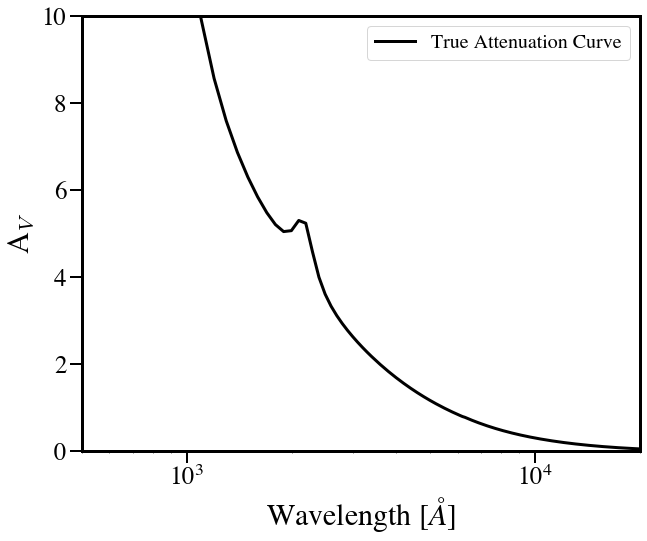

In [55]:
plt.plot(wav, true_curve, color='black', lw=3, label='True Attenuation Curve')
#plt.plot(wav, og_curve, color='deepskyblue', lw=3, label='Model = Observations')

#plt.plot(wav, fixed_curve, color='darkorange', lw=3, label='Model w/fixed nodust=0')
#plt.plot(wav, cal_curve, color='darkviolet', lw=3, label='Model = Calzetti')
plt.xscale('log')
plt.ylim([0, 10])
plt.xlim([5e2, 2e4])
plt.legend()
plt.ylabel('A$_V$')
plt.xlabel('Wavelength [$\AA$]')
#plt.savefig(savedir+'atten_curve.png', dpi=300, bbox_inches='tight')

In [42]:
def get_eff_atten_curve(nodust_sed, dust_sed):
    extinction = np.asarray(dust_sed) / np.asarray(nodust_sed)
    tau = -1.*np.log(extinction)
    return tau

In [44]:
attn_og = get_eff_atten_curve(spec_no_dust, spec_og)
attn_kc = get_eff_atten_curve(spec_no_dust, spec_kc)
attn_cal = get_eff_atten_curve(spec_no_dust, spec_cal)
attn_true = get_eff_atten_curve(spec_no_dust, spec_real)

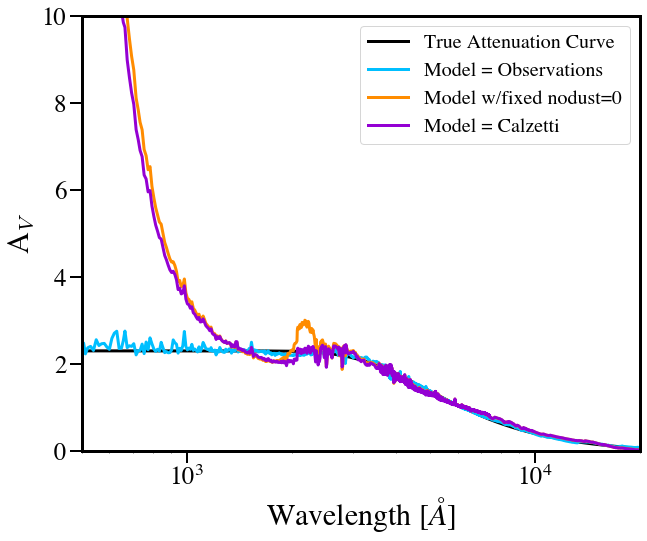

In [47]:
plt.plot(spec_waves, attn_true, color='black', lw=3, label='True Attenuation Curve')
plt.plot(spec_waves, attn_og, color='deepskyblue', lw=3, label='Model = Observations')

plt.plot(spec_waves, attn_kc, color='darkorange', lw=3, label='Model w/fixed nodust=0')
plt.plot(spec_waves, attn_cal, color='darkviolet', lw=3, label='Model = Calzetti')
plt.xscale('log')
plt.ylim([0, 10])
plt.xlim([5e2, 2e4])
plt.legend()
plt.ylabel('A$_V$')
plt.xlabel('Wavelength [$\AA$]')
plt.savefig(savedir+'eff_atten_curve.png', dpi=300, bbox_inches='tight')

In [56]:
res.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [58]:
res['model']

In [59]:
rescal['model']

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=50000000.0,maxi=10000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.9,maxi=0.2)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.3,sigma=1,mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=14.0)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=10)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)
  duste_gamma: <class 'prospect.models.priors.LogUniform'>(mini=0.001,maxi=0.15)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.1] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_dust_emission: [ True] 
  duste_qpah: [5.86] 
  lumdist: [1.e-05] 
  dust1: [0.] 
  dust_index: [-0.7] 
  frac_nodust: [0.] 
  uvb: [0.] 

In [60]:
rescal.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [61]:
pread.get_sps(rescal)

In [67]:
simba_dat = np.load('/Users/sidneylower/Documents/atten_demos/galaxy_10.npz', allow_pickle=True)

In [68]:
list(simba_dat.keys())

['data']

In [72]:
res_sim, _, mod_sim = pread.results_from('/Users/sidneylower/Documents/atten_demos/galaxy_10.h5')

In [71]:
mass50 = simba_dat['data'][()]['Mass_50']
mass16 = simba_dat['data'][()]['Mass_16']
mass84 = simba_dat['data'][()]['Mass_84']
truemass = simba_dat['data'][()]['True Mass']

In [74]:
res_sim.keys()

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])

In [95]:
new_file = res_sim['paramfile_text'].replace('sys.argv[1]', '0')
new_file = new_file.replace('np.loadtxt(mz_dir)', '0')

In [96]:
import os
param_file = (rescal['run_params'].get('param_file', ''),
                  new_file)
path, filename = os.path.split(param_file[0])
modname = filename.replace('.py', '')
user_module = pread.import_module_from_string(param_file[1], modname)

In [98]:
mod_sim = user_module.build_model(**res['run_params'])

loading model


In [99]:
thetas = mod_sim.theta_labels()

In [100]:
thetas

['dust2',
 'z_fraction_1',
 'z_fraction_2',
 'z_fraction_3',
 'z_fraction_4',
 'z_fraction_5',
 'z_fraction_6',
 'z_fraction_7',
 'z_fraction_8',
 'z_fraction_9',
 'total_mass',
 'duste_umin',
 'duste_gamma',
 'dust_index',
 'frac_nodust',
 'uvb',
 'massmet_1',
 'massmet_2']

In [102]:
simba_mass_post = [item[thetas.index('massmet_1')] for item in res_sim['chain']]

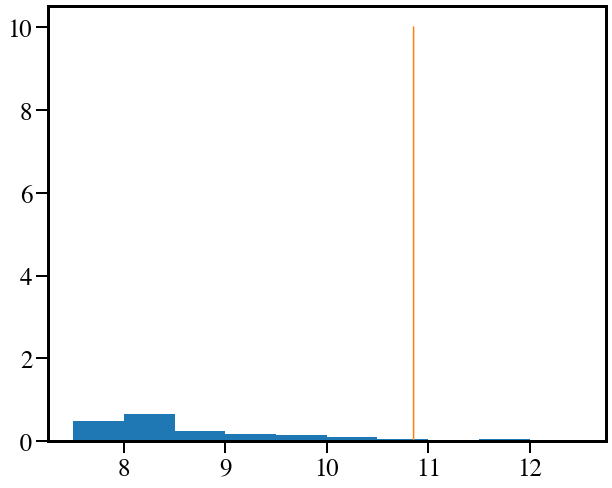

In [106]:
plt.hist(simba_mass_post, density=True)
plt.plot([np.log10(truemass/1.989e33), np.log10(truemass/1.9898e33)], [0, 10])

In [108]:
simba_nodust_post = [item[thetas.index('frac_nodust')] for item in res_sim['chain']]

(array([ 294.,  337.,  385.,  408.,  435.,  481.,  609., 1049., 1846.,
        1575.]),
 array([3.29963912e-05, 1.20291722e-02, 2.40253481e-02, 3.60215239e-02,
        4.80176997e-02, 6.00138756e-02, 7.20100514e-02, 8.40062273e-02,
        9.60024031e-02, 1.07998579e-01, 1.19994755e-01]),
 <a list of 10 Patch objects>)

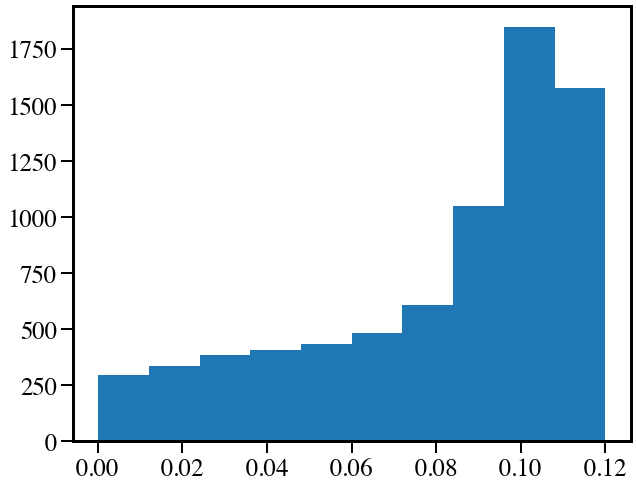

In [109]:
plt.hist(simba_nodust_post)

In [113]:
sps_sim = user_module.build_sps(**res['run_params'])

initiating sps


In [110]:
thetas_sim = get_best(res_sim)

In [120]:
spec_sim, _, _ = mod_sim.mean_model(thetas_sim, res['obs'], sps_sim)
sim_wav = sps_sim.wavelengths

In [116]:
from hyperion.model import ModelOutput
from astropy import units as u
from astropy import constants
m = ModelOutput("/Users/sidneylower/Documents/atten_demos/snap305.galaxy10.rtout.sed")
wav,flux = m.get_sed(inclination=0,aperture=-1)
wav  = np.asarray(wav)*u.micron #wav is in micron                                                                                                        
wav = wav.to(u.AA)
flux = np.asarray(flux)*u.erg/u.s
dl = (10. * u.pc).to(u.cm)
flux /= (4.*3.14*dl**2.)
nu = constants.c.cgs/(wav.to(u.cm))
nu = nu.to(u.Hz)
flux /= nu
flux = flux.to(u.Jy)
flux /= 3631

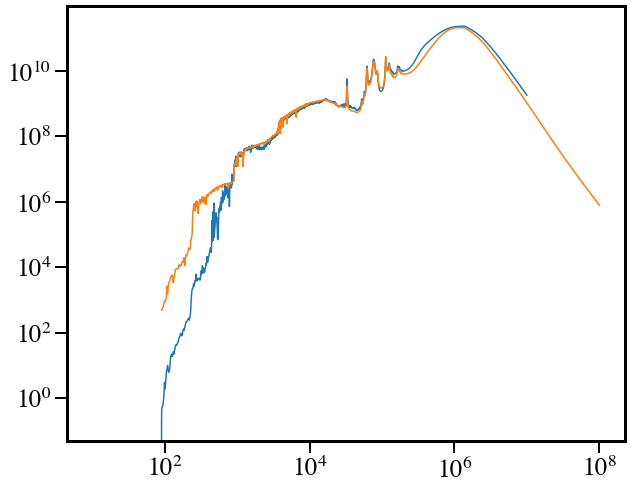

In [121]:
plt.loglog(wav, flux)
plt.loglog(sim_wav, spec_sim)

In [123]:
a = np.load('/Volumes/orange/narayanan/s.lower/simba/pyloser_los_extinction/pyloser_computeAV_galaxy10.npz')

In [126]:
import tqdm

In [156]:
frac_nodust_simba = []
Av_list = []
for i in tqdm.tqdm(range(2000)):
    try:
        dat = np.load('/Volumes/orange/narayanan/s.lower/simba/pyloser_los_extinction/pyloser_computeAV_galaxy'+str(i)+'.npz')
    except:
        continue 
    Av = dat['AV_per_star']
    Av_list.append([Av])
    nodust = np.where(np.log10(Av) < -8.)[0]
    total_stars = dat['stars']
    frac_nodust_simba.append(len(nodust) / total_stars)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2000/2000 [03:35<00:00,  9.26it/s]


In [168]:
frac = []
for i in tqdm.tqdm(range(len(Av_list))):
    nodust = np.where(np.log10(Av_list[i]) < -8.5)[0]
    frac.append(len(nodust) / len(Av_list[i]))
    

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2000/2000 [00:00<00:00, 32813.76it/s]


In [190]:
def nodust_fit(x, amp, tau):
    return amp*np.exp(-x*tau)

In [187]:
x = np.linspace(0, 0.5, 100)

(0, 1200)

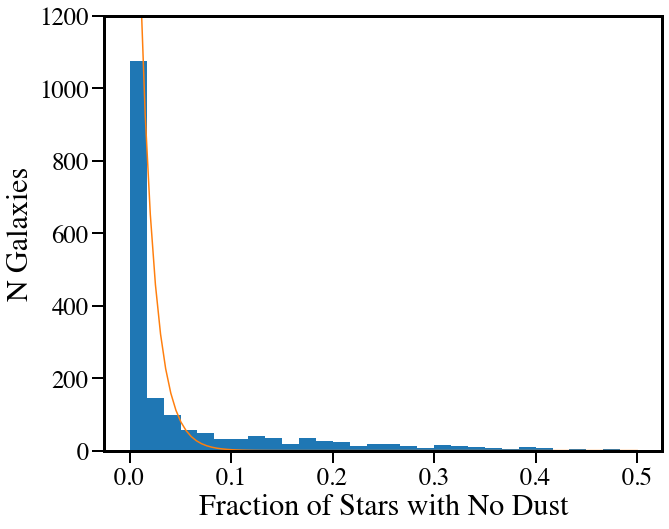

In [211]:
n, bins, _ = plt.hist(frac, bins=30, range=(0, 0.5))
plt.plot(x, nodust_fit(x, popt[0], 70))
plt.xlabel('Fraction of Stars with No Dust')
plt.ylabel('N Galaxies')
plt.ylim([0, 1200])
#plt.savefig('/Users/sidneylower/Documents/atten_demos/frac_nodust_simba_zoomout.png', dpi=300, bbox_inches='tight')

In [175]:
from scipy.optimize import curve_fit

In [202]:
midpoints = (bins[1:] + bins[:-1])/2

In [203]:
popt, pcov = curve_fit(nodust_fit, midpoints, n)

In [204]:
popt

array([2682.11763485,  110.0839214 ])

In [142]:
import yt

In [143]:
ds = yt.load('/Volumes/orange/narayanan/s.lower/simba/filtered_snapshots/snap305/galaxy_100.hdf5')

yt : [INFO     ] 2020-06-14 20:01:37,694 Calculating time from 1.000e+00 to be 4.375e+17 seconds
yt : [INFO     ] 2020-06-14 20:01:37,696 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-06-14 20:01:37,751 Parameters: current_time              = 4.3748565942961094e+17 s
yt : [INFO     ] 2020-06-14 20:01:37,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-06-14 20:01:37,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-06-14 20:01:37,755 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2020-06-14 20:01:37,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-06-14 20:01:37,758 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2020-06-14 20:01:37,759 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-06-14 20:01:37,761 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-06-14 20:01:37,761 Parameters: omega_radiation 

In [144]:
ad = ds.all_data()

yt : [INFO     ] 2020-06-14 20:01:55,075 Allocating for 2.204e+04 particles


In [146]:
ad[('PartType0', 'SmoothingLength')].in_units('kpc')

unyt_array([1.02941175, 1.16303063, 1.26131107, ..., 1.03014208,
            1.02941175, 1.03063084], 'kpc')

In [336]:
xdir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_xdir.npz', allow_pickle=True)
ydir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_ydir.npz', allow_pickle=True)
zdir = np.load('/Users/sidneylower/Documents/atten_demos/los_AV_caesar_per_galaxy_zdir.npz', allow_pickle=True)


avx = xdir['Av']
avy = ydir['Av']
avz = zdir['Av']

In [337]:
avs = []
for i in range(2000):
    stellar_av = np.array([avx[i], avy[i], avz[i]])
    gal_average = np.mean(stellar_av, axis=0)
    avs.append(gal_average)

/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


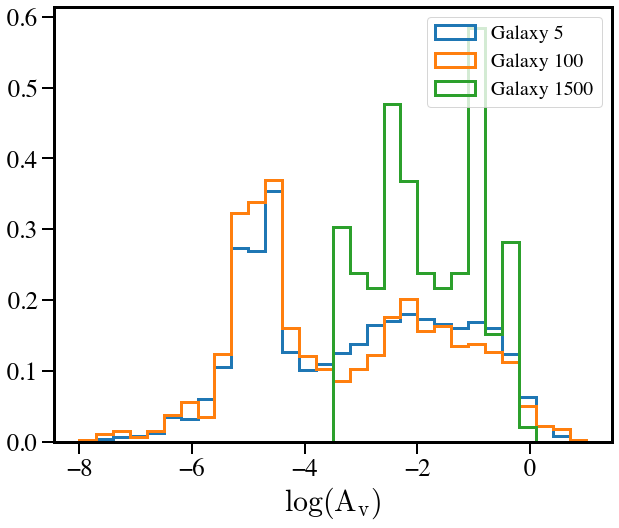

In [342]:
plt.hist(np.log10(avs[1]), range=(-8, 1), bins=30, histtype='step', lw=3,label='Galaxy '+str(5), density=True)
plt.hist(np.log10(avs[100]), range=(-8, 1), bins=30, histtype='step',lw=3,label='Galaxy '+str(100), density=True)
plt.hist(np.log10(avs[1500]), range=(-8, 1), bins=30, histtype='step',lw=3,label='Galaxy '+str(1500), density=True)
plt.legend()
plt.xlabel('$\log(\mathrm{A_v})$')
plt.savefig('/Users/sidneylower/Documents/atten_demos/av_galaxy_dist.png', dpi=300, bbox_inches='tight')

In [339]:
frac_nodust_0 = []
frac_nodust_2 = []
frac_nodust_5 = []
frac_nodust_8 = []
for i in range(2000):
    av_per_star = avs[i]
    nodust2 = len(np.where(np.log10(av_per_star) < -2)[0])
    nodust5 = len(np.where(np.log10(av_per_star) < -5)[0])
    nodust8 = len(np.where(np.log10(av_per_star) < -8)[0])
    nodust0 = len(np.where(av_per_star == 0.0 )[0])
    frac_nodust_0.append(nodust0 / len(av_per_star))
    frac_nodust_2.append(nodust2 / len(av_per_star))
    frac_nodust_5.append(nodust5 / len(av_per_star))
    frac_nodust_8.append(nodust8 / len(av_per_star))

/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/sidneylower/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


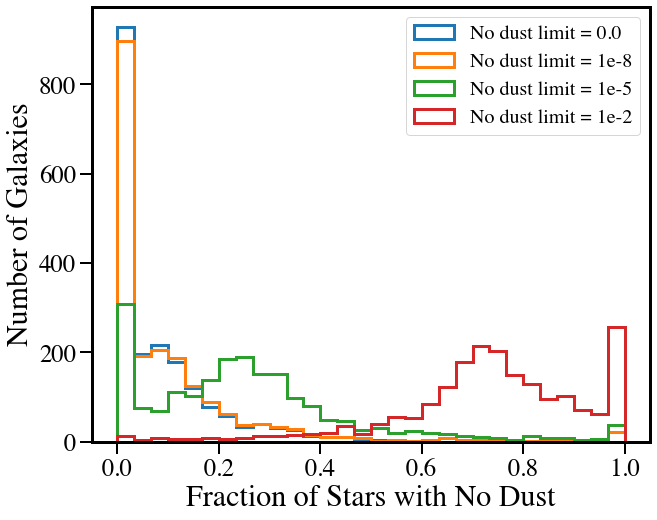

In [341]:
plt.hist(frac_nodust_0, bins=30, histtype='step', lw=3, label='No dust limit = 0.0')
plt.hist(frac_nodust_8, bins=30, histtype='step', lw=3, label='No dust limit = 1e-8')
plt.hist(frac_nodust_5, bins=30, histtype='step', lw=3, label='No dust limit = 1e-5')
plt.hist(frac_nodust_2, bins=30, histtype='step', lw=3, label='No dust limit = 1e-2')
plt.legend()
plt.xlabel('Fraction of Stars with No Dust')
plt.ylabel('Number of Galaxies')
plt.savefig(savedir+'/nodust_stars_all_galaxies.png', dpi=300, bbox_inches='tight')

In [329]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])